In [1]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import pickle

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !pip install catboost
    from catboost import CatBoostClassifier
    import os
    import urllib.request
    urllib.request.urlretrieve('https://raw.githubusercontent.com/doanthuan/viettelpay/master/util.py', 'util.py')
    from util import *
    DATA_DIR = "/content/drive/MyDrive/projects/viettelpay/code/data"
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print('Not running on CoLab')
    from catboost import CatBoostClassifier
    from util import *
    DATA_DIR = "data"

Not running on CoLab


In [3]:
pd.set_option('max_columns', None)
#pd.set_option("max_rows", None)

In [4]:
use_cols = [
    "request_date",
    "is_fraud",
    "province_code",
    "district_code",
    "viettel_bank_code",
    "channel_type_id",
    "channel_code",
    "staff_code",
    "trans_amount",
    "trans_fee",
    "trans_type",
    "process_code",
    "channel_fee",
    "shop_code",
    "customer_fee",
    "cust_name",
    "ben_cust_name",
    "msisdn",
    "ben_msisdn",
    "msisdn_channel",
    "staff_name"
]
train = pd.read_parquet(DATA_DIR+"/data-2m.snappy.parquet", columns=use_cols)
train.head()

,request_date,is_fraud,province_code,district_code,viettel_bank_code,channel_type_id,channel_code,staff_code,trans_amount,trans_fee,trans_type,process_code,channel_fee,shop_code,customer_fee,cust_name,ben_cust_name,msisdn,ben_msisdn,msisdn_channel,staff_name
0,2020-07-20 12:00:48,0,B651,B651004,KPP,1,1000810100_00608_DB,1000810100_00608_DB,8955989.0,1000.0,3,KPP301,770.0,1000810100_VTP,0.0,None,None,0001f092d1091229f963,None,0001f092d1091229f963,Dien Luc Loc Ninh_Nguyen Quang Huy
1,2020-07-20 06:06:26,0,L072,L072008,KPP,1,1000239100_00658_DB,1000239100_00658_DB,270614.0,1000.0,3,KPP301,770.0,1000239100_VTP,0.0,None,None,00019640e87c3bb7310b,None,000153defbfe4df71f2d,Tap hoa Thanh Thong-nguyen thi ngoc giau
2,2020-07-20 11:25:25,0,T008,T00802,MB,164,LAMHV5_VTPOST_HCM,LAMHV5_VTPOST_HCM,2000000.0,10000.0,2,400300,5500.0,1800590048,11000.0,nguyen van tiep,NGUYEN VAN TIEP,0001115a8f19769edb47,0001115a8f19769edb47,000165dac633c3b694c7,Huỳnh Văn Lắm
3,2020-07-20 14:17:50,0,T008,T00801,KPP,163,4400590001,4400590001,800000.0,8182.0,4,517000,7200.0,4400590001,18000.0,Ho Thi Loan,Tran Duy Khanh,00014835e613e06fa003,0001058a41c5c3c31af9,0001db3e096d46c51b2f,None
4,2020-07-20 02:49:25,0,H004,H004009,VIETTEL,164,THOMTT4_VTPOST_HNI,THOMTT4_VTPOST_HNI,912391.0,1200.0,3,666003,660.0,1800240011,0.0,Ngo Vi Thanh,Ngo Vi Thanh,000183d8f83cdd4fa068,None,00010d9d7268603b25b2,Trần Thị Thơm


In [5]:
account = pd.read_parquet(DATA_DIR+"/account_sale_mapping.snappy.parquet")
sale = pd.read_parquet(DATA_DIR+"/account_sale.snappy.parquet")

In [6]:
trans_hist = pd.read_parquet(DATA_DIR+"/trans_hist_2m.snappy.parquet")

In [7]:
train['ben_msisdn_enc'] = train.groupby('ben_msisdn')['is_fraud'].transform('mean')

In [8]:
features = [
#     "request_date",
#     "is_fraud",
    "province_code",
    "district_code",
    "viettel_bank_code",
    "channel_type_id",
    "channel_code",
    "staff_code",
    "trans_amount",
    "trans_fee",
    "trans_type",
    "process_code",
    "channel_fee",
    "shop_code",
    "customer_fee",
    "cust_name",
    "ben_cust_name",
    "msisdn",
    "ben_msisdn",
    "msisdn_channel",
    "staff_name",
    
    'ben_msisdn_enc',
    "msisdn_",
    "trans_amount_sum",
    "trans_amount_mean",
    
    "RW000076",
    "date_diff"
]

cat_features = [
    'viettel_bank_code',
    'msisdn_channel',
    'msisdn',
    'district_code',
    'process_code',
    'staff_code',
    'ben_msisdn',
    'shop_code',
    'province_code',
    'channel_code',
    'cust_name',
    'trans_type',
    'staff_name',
    'ben_cust_name',
    'channel_type_id',
    
    'msisdn_',
]

In [9]:
X, y = preprocess_data(train, account, sale, trans_hist, features, cat_features)

In [10]:
# y = train['is_fraud']
# X = train.drop(['is_fraud'], axis = 1)
# y_test = test['is_fraud']
# X_test = test.drop(['is_fraud'], axis = 1)
    
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=42)

In [11]:
cat_model = CatBoostClassifier(
    iterations=1000,
    max_ctr_complexity=1,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=100,
    depth=6,
    task_type="GPU",
    loss_function="Logloss",
    eval_metric="AUC"
)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val)
)

Learning rate set to 0.032217
0:	learn: 0.9136921	test: 0.9493538	best: 0.9493538 (0)	total: 329ms	remaining: 5m 28s
100:	learn: 0.9998268	test: 0.9998421	best: 0.9998421 (100)	total: 33.4s	remaining: 4m 57s
200:	learn: 0.9998734	test: 0.9998940	best: 0.9998940 (200)	total: 1m 6s	remaining: 4m 25s
300:	learn: 0.9998934	test: 0.9999157	best: 0.9999157 (299)	total: 1m 40s	remaining: 3m 53s
400:	learn: 0.9999046	test: 0.9999261	best: 0.9999261 (397)	total: 2m 13s	remaining: 3m 20s
500:	learn: 0.9999121	test: 0.9999332	best: 0.9999332 (499)	total: 2m 47s	remaining: 2m 46s
600:	learn: 0.9999179	test: 0.9999384	best: 0.9999384 (600)	total: 3m 21s	remaining: 2m 13s
700:	learn: 0.9999228	test: 0.9999428	best: 0.9999428 (699)	total: 3m 54s	remaining: 1m 40s
800:	learn: 0.9999265	test: 0.9999459	best: 0.9999459 (799)	total: 4m 28s	remaining: 1m 6s
900:	learn: 0.9999297	test: 0.9999487	best: 0.9999487 (898)	total: 5m 1s	remaining: 33.2s
999:	learn: 0.9999325	test: 0.9999507	best: 0.9999507 (990)	

In [12]:
#save_model(cat_model, 'cat-model.saved')
import gc
pickle.dump(cat_model, open('cat-model.saved', 'wb'))
del X, y, X_train, X_val, y_train, y_val
gc.collect()

22

In [13]:
loaded_cat_model = pickle.load(open('cat-model.saved', 'rb'))
test = pd.read_parquet(DATA_DIR+"/data-202008.snappy.parquet")

In [14]:
trans_hist = pd.read_parquet(DATA_DIR+"/trans_hist_202008.snappy.parquet")

In [43]:
test['ben_msisdn_enc'] = test['ben_msisdn'].map(train.groupby('ben_msisdn')['is_fraud'].mean())

global_mean = train["is_fraud"].mean()
test['ben_msisdn_enc'].fillna(global_mean, inplace=True)

In [44]:
X_test, y_test = preprocess_data(test, account, sale, trans_hist, features, cat_features)

In [45]:
eval_model(loaded_cat_model, X_test, y_test)

classification_report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7339993
           1       0.57      0.57      0.57     27674

    accuracy                           1.00   7367667
   macro avg       0.78      0.78      0.78   7367667
weighted avg       1.00      1.00      1.00   7367667

confusion_matrix: 
[[7327910   12083]
 [  11968   15706]]
roc_auc_score: 0.7829450644096634
precision_score: 0.5651876641836698
recall_score: 0.5675363156753631
f1_score: 0.5663595550186611


<AxesSubplot:>

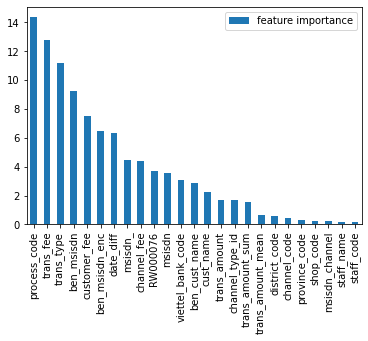

In [18]:
df_feature_importance = pd.DataFrame(loaded_cat_model.feature_importances_, index=features, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind='bar')

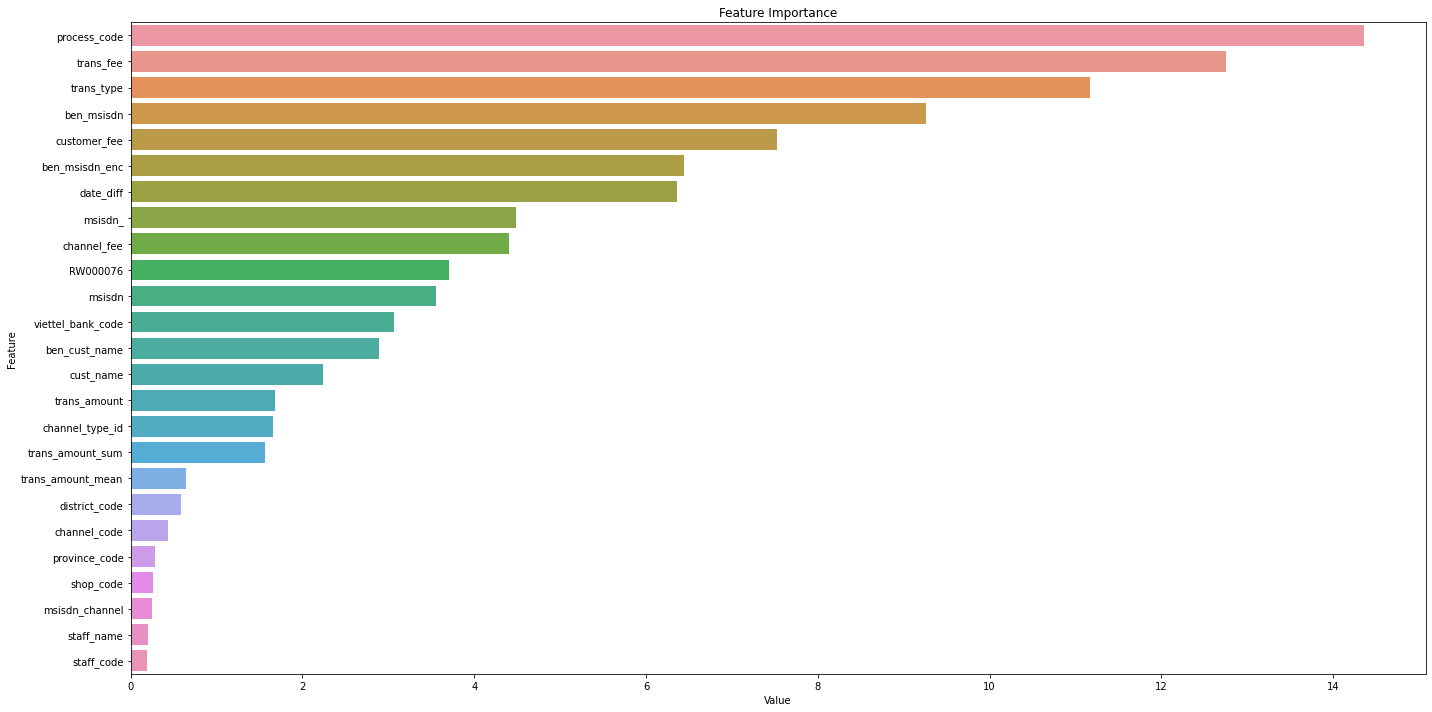

In [19]:
def plot_feature_importance(model, features):
    feature_importances = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value', 'Feature'])
    plt.figure(figsize=(20,10))
    sns.barplot(x="Value", y="Feature", data=feature_importances.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()
plot_feature_importance(loaded_cat_model, features)